# Section 4 Simulation Analysis

This document replicates the simulation result of CTD-GM-AR from Section 4 of Clustered Temporal Decomposition.

## Import required packages and define parameters

In [70]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import brokenaxes as bax
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

import util as util
import CTD_ARIMA
import data_generator as gen

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_idx=15
diff=1
K = 5
M = 4
N = 1000
l_max = 6
T = 300
T_future = 5
lambda_rate = (M * (N + T) * np.log(N + T))/ (N * T)

# Each column represents the diagonal elements
# of Theta_ell, for ell=0,1,2,..., ell_max.

AR_params = [[ 0., -0.5,  0.2,  0.,  0.2,  0.,   0.],
             [0.,  0.3,  -0.1,  0., 0,  0., 0.],
             [0., 0,   0,  0,  0.,  0.,  -0.6],
             [ 0., -0.05,   0.,   0., -0.4,  0.,  0.0],
             [0.,   0.2,  0.02, 0.2,  0.2,   0., 0.0],
             [0.,  0.1,  0. ,  0., 0.,    -.5,   -.1],
             [0.,  0.,  0.2,  0.5,  0.,  0., -0.],
            ]

# Each row represents the location of the center
# of the kth cluster

centers = np.array([[0.,  1., 0.0,  1.],
                   [0.,  0., 2.,  1.],
                   [0., -1., 0.,  -1.],
                   [1.,  .0, -0.0, -1.],
                   [-1., -.0, -0.0,  0.]])

# Each entry in row k column m represents the 
# standard deviation of the kth cluster along the mth axis

sigmas = (1/5) * np.array([[0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.],
                             [0.5 , 0.2, 1., 1.]])

## Determine one of sixteen cases

In [4]:

### Component 1: observational noise ###

Z_sd = 5. # Large noise
#Z_sd = 3. # Small noise


### Component 2: missing entries ###

#p_missing = 0.05 # 5% of entries missing 
p_missing = 0.00 # No missing entries


### Component 3: dimensional imbalance ###

#Small - keep current
#sigmas[:,2:] = (2/5) #large


### Component 4: Cluster distances ###

#close together - keep current
centers *= 5; sigmas *= 5 #Far away

## Generate observed data

The generated dataset can be visualized similarly as `Simple_Demo_With_Instructions.ipynb`. It is skipped here.

In [5]:
data = gen.Simulate(N=N,T=T+T_future,
        tmp_params=np.array(AR_params)[:M,:].T, 
        centers=centers,
        Z_sd=Z_sd,
        sigmas=sigmas,
        p_missing=p_missing,
        difference=diff,
        seed=dataset_idx,
        AR_sd=0.2,
        torch_device=device)
data.generate()

## Plotting function

In [54]:
def plot_with_brokenaxes(CTD_data, TRMF_data, line_loc, ax,
                        title=None, ylab=None, xlab=None, legend_off=True):
    
    if not legend_off:
        hist_labels = ["CTD", "Base1"]
        base_label = "ARIMA Baseline"
    else:
        hist_labels = None
        base_label = None
    
    if line_loc is None:
        axx = fig.add_subplot(ax)
        y, _, _ = axx.hist([CTD_data, TRMF_data], label=hist_labels, 
                           color=["#1F1D2E","#B2BEB5"])
        axx.spines[['right', 'top']].set_visible(False)
        if title:
            axx.set_title(title)
        if ylab:
            axx.set_ylabel(ylab)
        if xlab:
            axx.set_xlabel(xlab)
        axx.legend()
            
    elif max(CTD_data.max(), TRMF_data.max())+0.02 > line_loc:
        axx = fig.add_subplot(ax)
        y, _, _ = axx.hist([CTD_data, TRMF_data], label=hist_labels, 
                           color=["#1F1D2E","#B2BEB5"])
        axx.vlines(x=line_loc, ymin=0, ymax=y.max(),  
                   color="red", linestyles="dashed", label=base_label)
        axx.spines[['right', 'top']].set_visible(False)
            
        if title:
            axx.set_title(title)
        if ylab:
            axx.set_ylabel(ylab)
        if xlab:
            axx.set_xlabel(xlab)
            
        axx.legend()
            
    else:
        xlims1 = (min(CTD_data.min(), TRMF_data.min())*.995, max(CTD_data.max(), TRMF_data.max())*1.01)
        xlims2 = (line_loc*0.95, line_loc * 1.01)
        bax = brokenaxes(xlims=(xlims1, xlims2), subplot_spec=ax)
        (y1, _, _), (y2, _, _) = bax.hist([CTD_data, TRMF_data], 
                                          label=hist_labels, 
                                          color=["#1F1D2E","#B2BEB5"], hatch=["&",'/'])
        bax.vlines(x=line_loc, ymin=0, ymax=max(y1.max(), y2.max()),  
                   color="red", linestyles="dashed", label=base_label)
        if title:
            bax.set_title(title)
        if ylab:
            bax.set_ylabel(ylab)
        if xlab:
            bax.set_xlabel(xlab)
            
        bax.legend()

## Baseline ARIMA

In [78]:
#The baseline ARIMA provides an analytical answer. It is only ran once.

baseline_history = torch.empty((N,T))
baseline_forecast = torch.empty((N, T_future))
data_np = data.Z_obs.detach().cpu().numpy()

for i in range(N):
    print(f"Processing row {i+1}", end="\r")
    model = ARIMA(data_np[i,:T], order=(l_max,1,0)).fit()
    baseline_history[i, :] =torch.tensor(model.predict())
    baseline_forecast[i,:] = torch.tensor(model.forecast(T_future))

base_future = util.compute_est_performance(pred=baseline_forecast, 
                     truth=data.Z_star[:, T:T+T_future], 
                     history=data.Z_star[:, :T],
                     method_name="ARIMA_base",
                     idx=None,
                     save_to=None)

base_history = util.compute_est_performance(pred=baseline_history, 
             truth=data.Z_star[:, :T], 
             history=data.Z_star[:, :T],
             method_name="ARIMA_base",
             idx=None,save_to=None)

## Run 100 loops of CTD-GM-AR and TRMF

CTD seed 0 begins
## Pretraining done after loop 1285 | pretrain loss 24.717450810426335
Loop 100 | overall_loss 25.7187 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.7991 | x 0.0003 | y 0.0001 
Training finished | loop 227
overall 24.7808 | x 0.0002 | y 0.0001
TRMF seed 0 begins
## Pretraining done after loop 1285 | pretrain loss 24.717450810426335
Loop 200 | overall_loss 24.7747 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7153 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7153 | x 0.0 | y 0.0001
CTD seed 1 begins
## Pretraining done after loop 1214 | pretrain loss 24.995357039226295
Loop 100 | overall_loss 25.9545 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0507 | x 0.0003 | y 0.0001 
Loop 300 | overall_loss 24.9745 | x 0.0002 | y 0.0001 
Training finished | loop 301
overall 24.9751 | x 0.0002 | y 0.0001
TRMF seed 1 begins
## Pretraining done after loop 1214 | pretrain loss 24.995357039226295
Loop 200 | overall_loss 25.0347 | x 0.0 | y 0.0001 
Loop 400 | ov

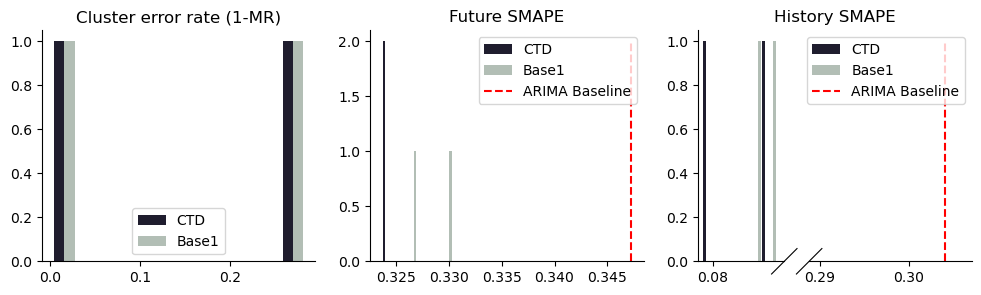

CTD seed 2 begins
## Pretraining done after loop 1332 | pretrain loss 24.74301385547698
Loop 100 | overall_loss 25.8631 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.8285 | x 0.0002 | y 0.0001 
Training finished | loop 229
overall 24.8135 | x 0.0002 | y 0.0001
TRMF seed 2 begins
## Pretraining done after loop 1332 | pretrain loss 24.74301385547698
Loop 200 | overall_loss 24.8065 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.736 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7359 | x 0.0 | y 0.0001
CTD seed 3 begins
## Pretraining done after loop 1301 | pretrain loss 24.74293012821178
Loop 100 | overall_loss 25.6224 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.7981 | x 0.0003 | y 0.0001 
Training finished | loop 250
overall 24.755 | x 0.0002 | y 0.0001
TRMF seed 3 begins
## Pretraining done after loop 1301 | pretrain loss 24.74293012821178
Loop 200 | overall_loss 24.7804 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7304 | x 0.0 | y 0.0001 
Training finished | lo

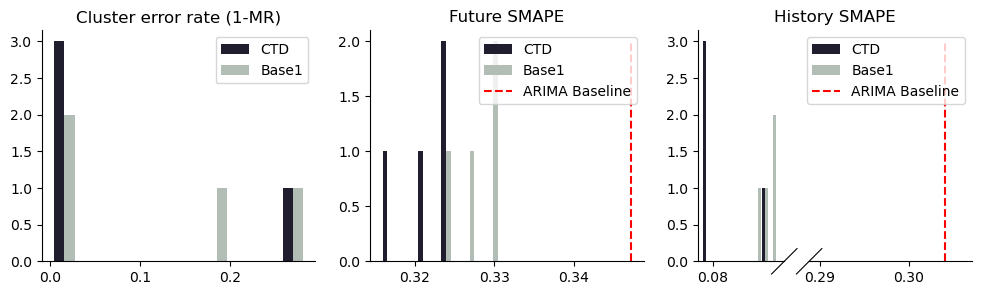

CTD seed 4 begins
## Pretraining done after loop 1220 | pretrain loss 24.98715866162569
Loop 100 | overall_loss 25.9623 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.053 | x 0.0003 | y 0.0002 
Training finished | loop 252
overall 25.0201 | x 0.0001 | y 0.0002
TRMF seed 4 begins
## Pretraining done after loop 1220 | pretrain loss 24.98715866162569
Loop 200 | overall_loss 25.0345 | x 0.0 | y 0.0002 
Loop 400 | overall_loss 24.9571 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.9569 | x 0.0 | y 0.0001
CTD seed 5 begins
## Pretraining done after loop 1282 | pretrain loss 25.000881884450926
Loop 100 | overall_loss 25.9882 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0751 | x 0.0003 | y 0.0002 
Training finished | loop 236
overall 25.0602 | x 0.0002 | y 0.0002
TRMF seed 5 begins
## Pretraining done after loop 1282 | pretrain loss 25.000881884450926
Loop 200 | overall_loss 25.0539 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 25.0051 | x 0.0 | y 0.0001 
Training finished |

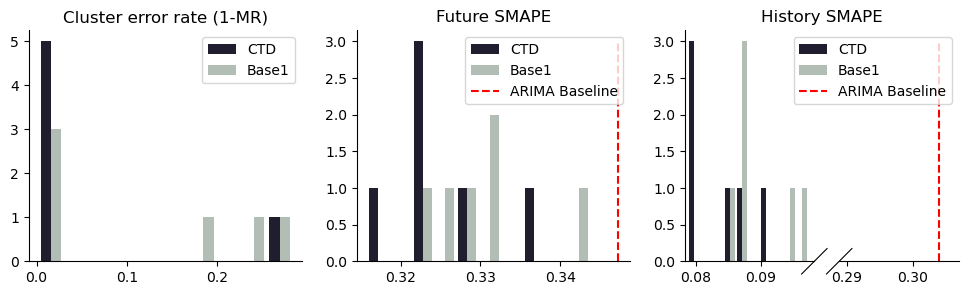

CTD seed 6 begins
## Pretraining done after loop 1493 | pretrain loss 24.721071033775598
Loop 100 | overall_loss 25.6359 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.789 | x 0.0003 | y 0.0001 
Training finished | loop 294
overall 24.7714 | x 0.0001 | y 0.0001
TRMF seed 6 begins
## Pretraining done after loop 1493 | pretrain loss 24.721071033775598
Loop 200 | overall_loss 24.7767 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7202 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7201 | x 0.0 | y 0.0001
CTD seed 7 begins
## Pretraining done after loop 1204 | pretrain loss 25.0061213591197
Loop 100 | overall_loss 26.0867 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0883 | x 0.0003 | y 0.0001 
Training finished | loop 282
overall 25.0406 | x 0.0003 | y 0.0001
TRMF seed 7 begins
## Pretraining done after loop 1204 | pretrain loss 25.0061213591197
Loop 200 | overall_loss 25.0743 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 25.0047 | x 0.0 | y 0.0001 
Training finished | l

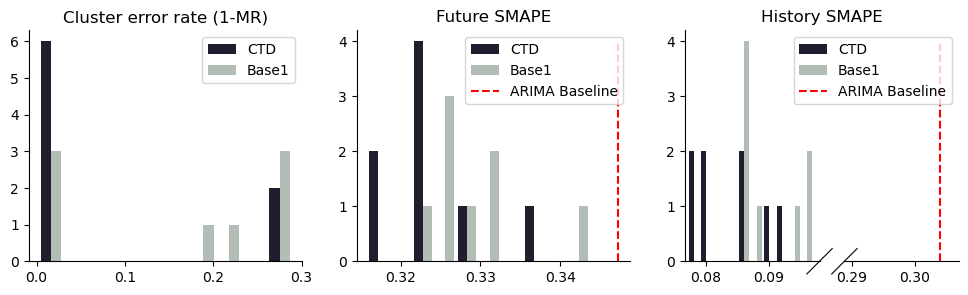

CTD seed 8 begins
## Pretraining done after loop 1316 | pretrain loss 24.72593533124599
Loop 100 | overall_loss 25.7773 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.8068 | x 0.0003 | y 0.0001 
Training finished | loop 235
overall 24.774 | x 0.0002 | y 0.0001
TRMF seed 8 begins
## Pretraining done after loop 1316 | pretrain loss 24.72593533124599
Loop 200 | overall_loss 24.7898 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7214 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7214 | x 0.0 | y 0.0001
CTD seed 9 begins
## Pretraining done after loop 1359 | pretrain loss 24.717462385248684
Loop 100 | overall_loss 25.5197 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.7758 | x 0.0003 | y 0.0001 
Training finished | loop 238
overall 24.749 | x 0.0002 | y 0.0001
TRMF seed 9 begins
## Pretraining done after loop 1359 | pretrain loss 24.717462385248684
Loop 200 | overall_loss 24.7563 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.718 | x 0.0 | y 0.0001 
Training finished | l

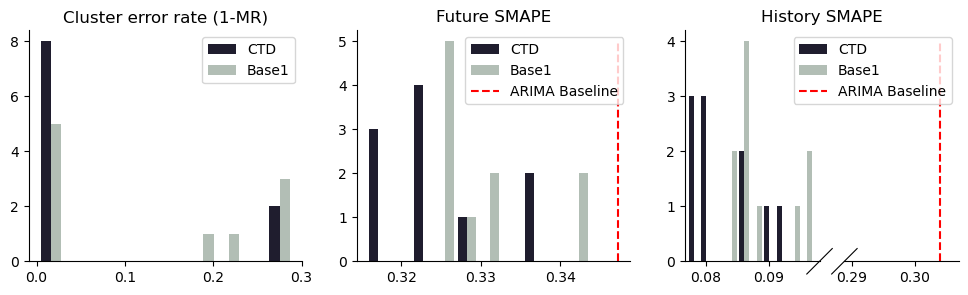

CTD seed 10 begins
## Pretraining done after loop 1331 | pretrain loss 24.72535908278642
Loop 100 | overall_loss 25.7454 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.8023 | x 0.0003 | y 0.0001 
Training finished | loop 231
overall 24.7791 | x 0.0002 | y 0.0001
TRMF seed 10 begins
## Pretraining done after loop 1331 | pretrain loss 24.72535908278642
Loop 200 | overall_loss 24.7819 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7237 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7237 | x 0.0 | y 0.0001
CTD seed 11 begins
## Pretraining done after loop 1453 | pretrain loss 24.72829590847878
Loop 100 | overall_loss 25.6527 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.8042 | x 0.0002 | y 0.0001 
Training finished | loop 234
overall 24.7851 | x 0.0002 | y 0.0001
TRMF seed 11 begins
## Pretraining done after loop 1453 | pretrain loss 24.72829590847878
Loop 200 | overall_loss 24.7874 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7275 | x 0.0 | y 0.0001 
Training finishe

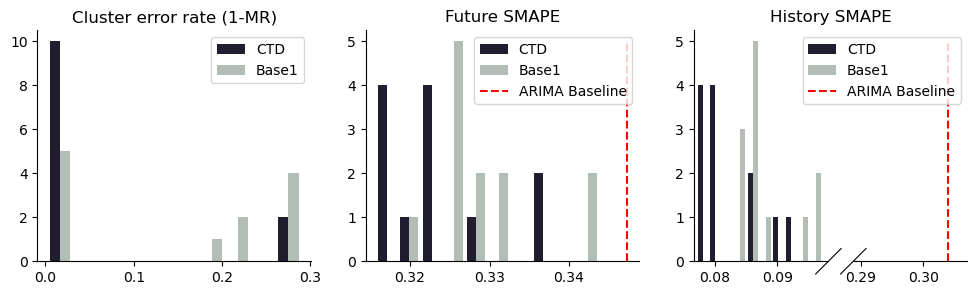

CTD seed 12 begins
## Pretraining done after loop 1380 | pretrain loss 24.987770431475422
Loop 100 | overall_loss 25.8281 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0672 | x 0.0003 | y 0.0002 
Training finished | loop 228
overall 25.0563 | x 0.0002 | y 0.0002
TRMF seed 12 begins
## Pretraining done after loop 1380 | pretrain loss 24.987770431475422
Loop 200 | overall_loss 25.0414 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 25.0006 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 25.0005 | x 0.0 | y 0.0001
CTD seed 13 begins
## Pretraining done after loop 1303 | pretrain loss 24.7262289646822
Loop 100 | overall_loss 25.6589 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.7951 | x 0.0002 | y 0.0001 
Training finished | loop 224
overall 24.7839 | x 0.0002 | y 0.0001
TRMF seed 13 begins
## Pretraining done after loop 1303 | pretrain loss 24.7262289646822
Loop 200 | overall_loss 24.7703 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7234 | x 0.0 | y 0.0001 
Training finishe

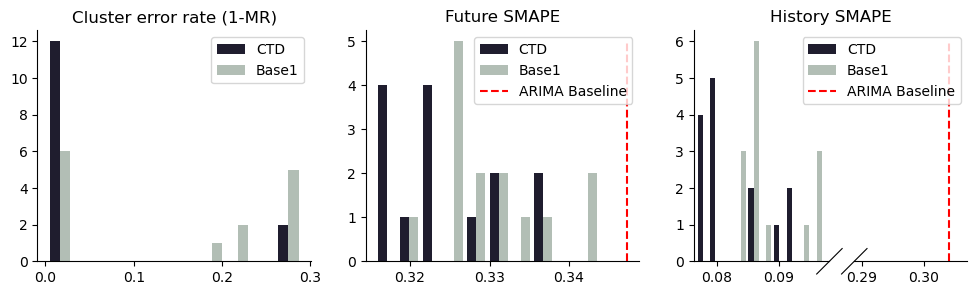

CTD seed 14 begins
## Pretraining done after loop 1257 | pretrain loss 24.726950785575372
Loop 100 | overall_loss 25.6567 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.8024 | x 0.0003 | y 0.0001 
Training finished | loop 230
overall 24.7948 | x 0.0002 | y 0.0001
TRMF seed 14 begins
## Pretraining done after loop 1257 | pretrain loss 24.726950785575372
Loop 200 | overall_loss 24.7763 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7248 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.724 | x 0.0 | y 0.0001
CTD seed 15 begins
## Pretraining done after loop 1319 | pretrain loss 24.729152162855748
Loop 100 | overall_loss 25.8607 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.8281 | x 0.0003 | y 0.0001 
Training finished | loop 216
overall 24.8205 | x 0.0002 | y 0.0001
TRMF seed 15 begins
## Pretraining done after loop 1319 | pretrain loss 24.729152162855748
Loop 200 | overall_loss 24.7995 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7272 | x 0.0 | y 0.0001 
Training fini

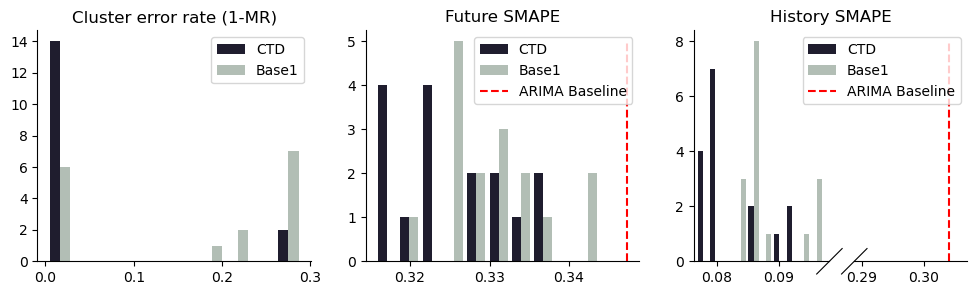

CTD seed 16 begins
## Pretraining done after loop 1247 | pretrain loss 24.99806743809972
Loop 100 | overall_loss 26.0147 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0649 | x 0.0003 | y 0.0001 
Training finished | loop 269
overall 25.0425 | x 0.0002 | y 0.0001
TRMF seed 16 begins
## Pretraining done after loop 1247 | pretrain loss 24.99806743809972
Loop 200 | overall_loss 25.0493 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 25.0039 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 25.0033 | x 0.0 | y 0.0001
CTD seed 17 begins
## Pretraining done after loop 1349 | pretrain loss 24.72078275903157
Loop 100 | overall_loss 25.7646 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.8092 | x 0.0003 | y 0.0001 
Training finished | loop 229
overall 24.7975 | x 0.0002 | y 0.0001
TRMF seed 17 begins
## Pretraining done after loop 1349 | pretrain loss 24.72078275903157
Loop 200 | overall_loss 24.7923 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7153 | x 0.0 | y 0.0001 
Training finishe

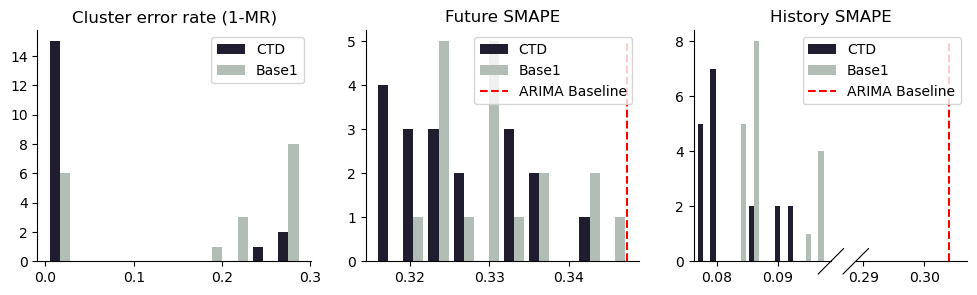

CTD seed 18 begins
## Pretraining done after loop 1354 | pretrain loss 24.72420447546257
Loop 100 | overall_loss 25.717 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.8021 | x 0.0002 | y 0.0001 
Training finished | loop 215
overall 24.7996 | x 0.0002 | y 0.0001
TRMF seed 18 begins
## Pretraining done after loop 1354 | pretrain loss 24.72420447546257
Loop 200 | overall_loss 24.7709 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7218 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7217 | x 0.0 | y 0.0001
CTD seed 19 begins
## Pretraining done after loop 1372 | pretrain loss 24.988624238323855
Loop 100 | overall_loss 25.9597 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0213 | x 0.0003 | y 0.0001 
Loop 300 | overall_loss 24.9008 | x 0.0001 | y 0.0001 
Training finished | loop 301
overall 24.9017 | x 0.0001 | y 0.0001
TRMF seed 19 begins
## Pretraining done after loop 1372 | pretrain loss 24.988624238323855
Loop 200 | overall_loss 25.0123 | x 0.0 | y 0.0001 
Loop 400 | o

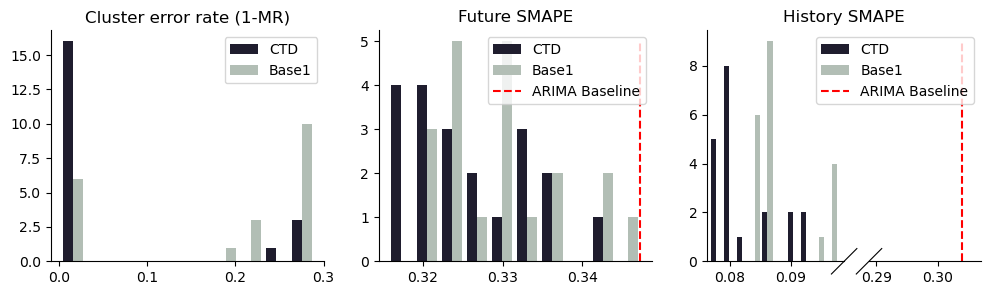

CTD seed 20 begins
## Pretraining done after loop 1371 | pretrain loss 24.74247583592064
Loop 100 | overall_loss 25.7263 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.8279 | x 0.0003 | y 0.0001 
Training finished | loop 233
overall 24.8103 | x 0.0002 | y 0.0001
TRMF seed 20 begins
## Pretraining done after loop 1371 | pretrain loss 24.74247583592064
Loop 200 | overall_loss 24.8069 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7363 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7324 | x 0.0 | y 0.0001
CTD seed 21 begins
## Pretraining done after loop 1365 | pretrain loss 24.70824452881445
Loop 100 | overall_loss 25.6877 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.7857 | x 0.0003 | y 0.0001 
Loop 300 | overall_loss 24.7358 | x 0.0003 | y 0.0001 
Training finished | loop 381
overall 24.7355 | x 0.0003 | y 0.0001
TRMF seed 21 begins
## Pretraining done after loop 1365 | pretrain loss 24.70824452881445
Loop 200 | overall_loss 24.7735 | x 0.0 | y 0.0001 
Loop 400 | ov

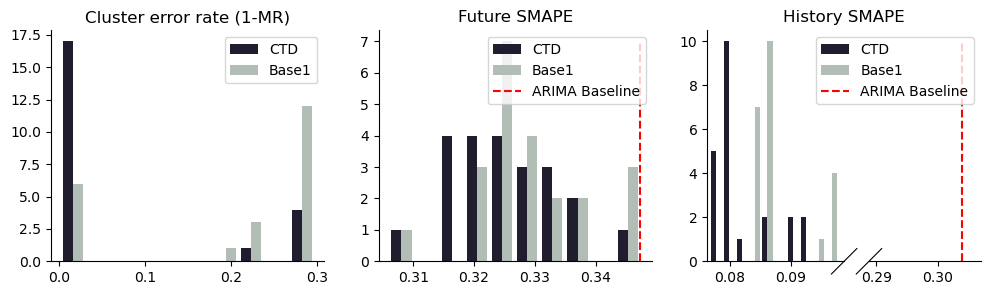

CTD seed 22 begins
## Pretraining done after loop 1219 | pretrain loss 24.97513870064431
Loop 100 | overall_loss 25.9208 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0174 | x 0.0003 | y 0.0001 
Loop 300 | overall_loss 24.8595 | x 0.0002 | y 0.0001 
Training finished | loop 318
overall 24.857 | x 0.0001 | y 0.0001
TRMF seed 22 begins
## Pretraining done after loop 1219 | pretrain loss 24.97513870064431
Loop 200 | overall_loss 25.0011 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7567 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7554 | x 0.0 | y 0.0001
CTD seed 23 begins
## Pretraining done after loop 1286 | pretrain loss 24.70934452918534
Loop 100 | overall_loss 25.6076 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.8049 | x 0.0002 | y 0.0001 
Training finished | loop 220
overall 24.7957 | x 0.0003 | y 0.0001
TRMF seed 23 begins
## Pretraining done after loop 1286 | pretrain loss 24.70934452918534
Loop 200 | overall_loss 24.774 | x 0.0 | y 0.0001 
Loop 400 | over

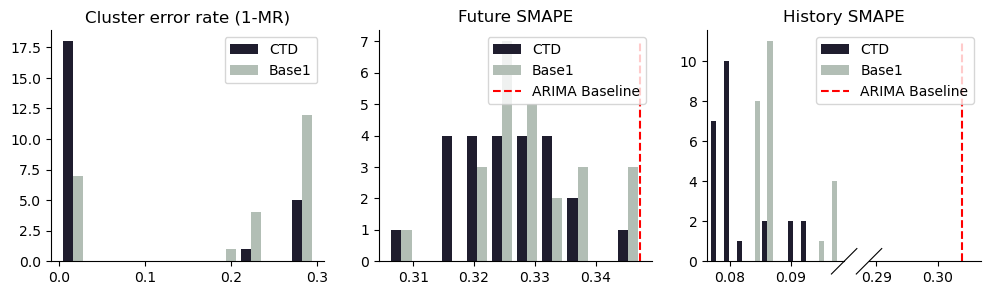

CTD seed 24 begins
## Pretraining done after loop 1220 | pretrain loss 24.996804927408167
Loop 100 | overall_loss 26.0439 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0429 | x 0.0003 | y 0.0001 
Training finished | loop 268
overall 25.0001 | x 0.0002 | y 0.0001
TRMF seed 24 begins
## Pretraining done after loop 1220 | pretrain loss 24.996804927408167
Loop 200 | overall_loss 25.0251 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.9781 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.978 | x 0.0 | y 0.0001
CTD seed 25 begins
## Pretraining done after loop 1303 | pretrain loss 24.739904732277818
Loop 100 | overall_loss 25.8315 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.814 | x 0.0003 | y 0.0001 
Training finished | loop 243
overall 24.7835 | x 0.0002 | y 0.0001
TRMF seed 25 begins
## Pretraining done after loop 1303 | pretrain loss 24.739904732277818
Loop 200 | overall_loss 24.7965 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7269 | x 0.0 | y 0.0001 
Training finis

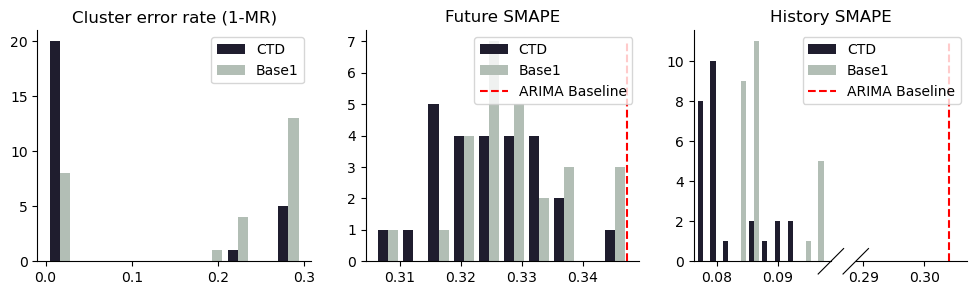

CTD seed 26 begins
## Pretraining done after loop 1255 | pretrain loss 24.99417801831684
Loop 100 | overall_loss 25.9254 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0566 | x 0.0003 | y 0.0002 
Training finished | loop 237
overall 25.0405 | x 0.0002 | y 0.0002
TRMF seed 26 begins
## Pretraining done after loop 1255 | pretrain loss 24.99417801831684
Loop 200 | overall_loss 25.036 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 25.0022 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 25.0021 | x 0.0 | y 0.0001
CTD seed 27 begins
## Pretraining done after loop 1291 | pretrain loss 24.950051822352282
Loop 100 | overall_loss 25.9631 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.964 | x 0.0003 | y 0.0001 
Loop 300 | overall_loss 24.8183 | x 0.0003 | y 0.0001 
Training finished | loop 375
overall 24.7949 | x 0.0001 | y 0.0001
TRMF seed 27 begins
## Pretraining done after loop 1291 | pretrain loss 24.950051822352282
Loop 200 | overall_loss 24.9582 | x 0.0 | y 0.0001 
Loop 400 | ov

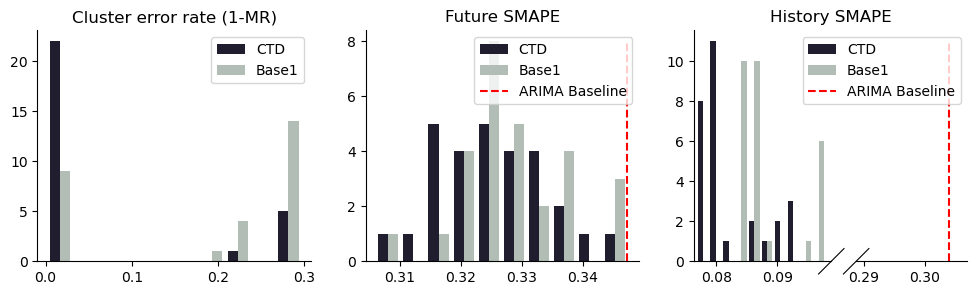

CTD seed 28 begins
## Pretraining done after loop 1313 | pretrain loss 24.72840917395725
Loop 100 | overall_loss 25.6214 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.8013 | x 0.0002 | y 0.0001 
Training finished | loop 229
overall 24.7948 | x 0.0002 | y 0.0001
TRMF seed 28 begins
## Pretraining done after loop 1313 | pretrain loss 24.72840917395725
Loop 200 | overall_loss 24.7734 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.727 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7266 | x 0.0 | y 0.0001
CTD seed 29 begins
## Pretraining done after loop 1203 | pretrain loss 24.994786739179514
Loop 100 | overall_loss 26.0145 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0652 | x 0.0003 | y 0.0001 
Training finished | loop 255
overall 25.0494 | x 0.0002 | y 0.0001
TRMF seed 29 begins
## Pretraining done after loop 1203 | pretrain loss 24.994786739179514
Loop 200 | overall_loss 25.0465 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 25.0028 | x 0.0 | y 0.0001 
Training finish

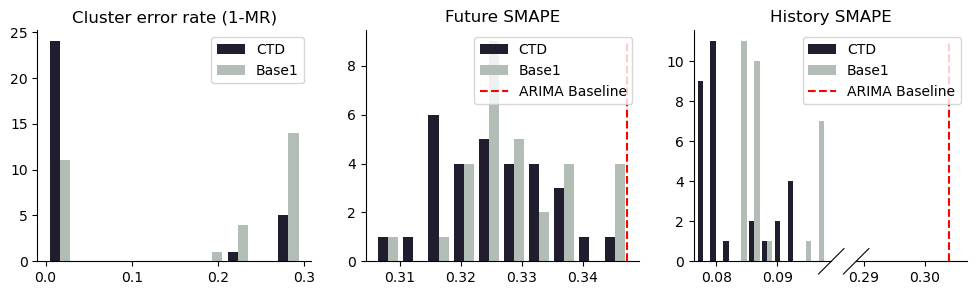

CTD seed 30 begins
## Pretraining done after loop 1336 | pretrain loss 24.731004584029748
Loop 100 | overall_loss 25.6578 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.7964 | x 0.0003 | y 0.0001 
Training finished | loop 232
overall 24.7743 | x 0.0002 | y 0.0001
TRMF seed 30 begins
## Pretraining done after loop 1336 | pretrain loss 24.731004584029748
Loop 200 | overall_loss 24.7802 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.723 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7227 | x 0.0 | y 0.0001
CTD seed 31 begins
## Pretraining done after loop 1342 | pretrain loss 24.735265461691686
Loop 100 | overall_loss 25.8051 | x 0.0004 | y 0.0001 
Loop 200 | overall_loss 24.805 | x 0.0003 | y 0.0001 
Training finished | loop 277
overall 24.7823 | x 0.0003 | y 0.0001
TRMF seed 31 begins
## Pretraining done after loop 1342 | pretrain loss 24.735265461691686
Loop 200 | overall_loss 24.787 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7268 | x 0.0 | y 0.0001 
Training finish

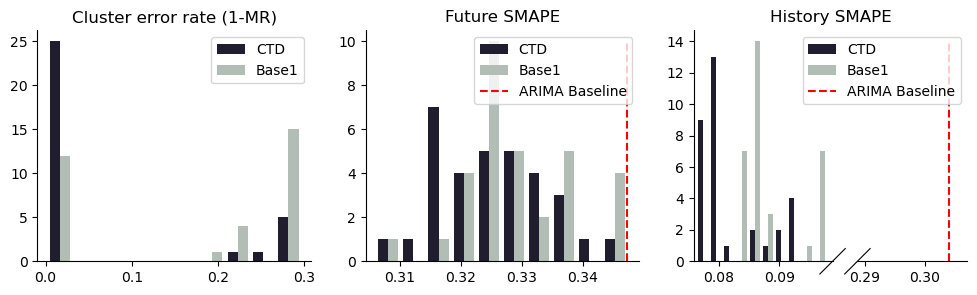

CTD seed 32 begins
## Pretraining done after loop 1327 | pretrain loss 24.743880301485934
Loop 100 | overall_loss 25.7912 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.8197 | x 0.0003 | y 0.0001 
Loop 300 | overall_loss 24.7613 | x 0.0003 | y 0.0001 
Training finished | loop 307
overall 24.7632 | x 0.0002 | y 0.0001
TRMF seed 32 begins
## Pretraining done after loop 1327 | pretrain loss 24.743880301485934
Loop 200 | overall_loss 24.8016 | x 0.0 | y 0.0001 
Loop 400 | overall_loss 24.7253 | x 0.0 | y 0.0001 
Training finished | loop 500
overall 24.7217 | x 0.0 | y 0.0001
CTD seed 33 begins
## Pretraining done after loop 1272 | pretrain loss 24.75183938488382
Loop 100 | overall_loss 25.7313 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 24.8145 | x 0.0003 | y 0.0001 
Training finished | loop 258
overall 24.777 | x 0.0002 | y 0.0001
TRMF seed 33 begins
## Pretraining done after loop 1272 | pretrain loss 24.75183938488382
Loop 200 | overall_loss 24.8022 | x 0.0 | y 0.0001 
Loop 400 | o

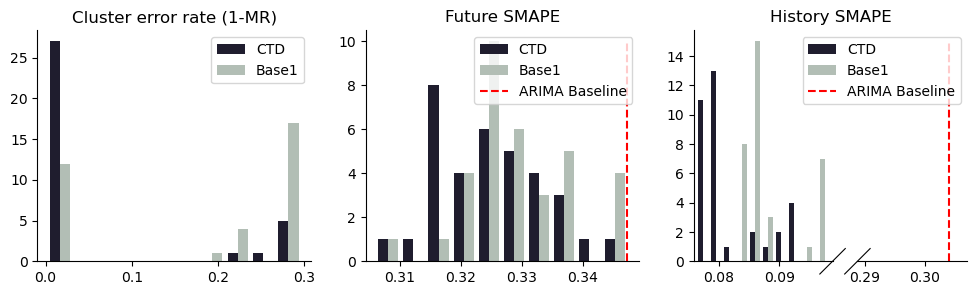

CTD seed 34 begins
## Pretraining done after loop 1229 | pretrain loss 24.999884105631082
Loop 100 | overall_loss 25.8035 | x 0.0004 | y 0.0002 
Loop 200 | overall_loss 25.0626 | x 0.0003 | y 0.0001 
Training finished | loop 237
overall 25.0527 | x 0.0002 | y 0.0001
TRMF seed 34 begins
## Pretraining done after loop 1229 | pretrain loss 24.999884105631082


In [ ]:
xy_multiplier = 1e-3
graphing_freq = 2
tmp_metric = "SMAPE" #"NRMSE"
    
CTD_hist_table = None
CTD_future_table = None
CTD_cluster_table = None
TRMF_hist_table = None
TRMF_future_table = None
TRMF_cluster_table = None

for seed in range(100):
    #Run CTD-GM-AR
        
    print(f"CTD seed {seed} begins")
    fitter_full = CTD_ARIMA.CTD(Z_obs = data.Z_obs[:,:T],
                     AR_lags=torch.arange(l_max) + 1, 
                     difference=diff,
                     K = K, 
                     M = M,
                     rbsize=1000,
                     cbsize=300,
                     lambda_all = 1e-3 * lambda_rate,
                     lambda_x = xy_multiplier * lambda_rate,
                     lambda_y = xy_multiplier * lambda_rate,
                     lr=0.005,
                     verbosity=100,
                     seed=seed,
                     pre_patience=5,
                     patience=5,
                     device='cuda') 
    fitter_full.fit(noise=0.5, max_loop=500)
    
    ######Compute performance and save####
    CTD_cluster_error = util.compute_cluster_performance(fitter_full.soft_labels, data.labels)
    cluster_tmp = util.compute_cluster_baselines(data.Z_obs[:,:T], M, data.labels, 
                                                       CTD_result=CTD_cluster_error,
                                                       seed=seed, save_to=None)
    if CTD_cluster_table is None:
        CTD_cluster_table = cluster_tmp
    else:
        CTD_cluster_table.loc[len(CTD_cluster_table.index)] = cluster_tmp.loc[0]

    CTD_hist_est = fitter_full.Z_hat().detach().cpu().numpy()
    CTD_future_est = fitter_full.predict(T_future).detach().cpu().numpy()

    future_tmp = util.compute_est_performance(pred=CTD_future_est[:,:T_future], 
                                 truth=data.Z_star[:, T:T+T_future], 
                                 history=data.Z_star[:, :T],
                                 method_name="ARIMA_forecast",
                                 idx=seed, save_to=None)
    if CTD_future_table is None:
        CTD_future_table = future_tmp
    else:
        CTD_future_table.loc[len(CTD_future_table.index)] = future_tmp.loc[0]

    hist_tmp = util.compute_est_performance(pred=CTD_hist_est, 
                                 truth=data.Z_star[:, :T], 
                                 history=data.Z_star[:, :T],
                                 method_name="ARIMA_history",
                                 idx=seed, save_to=None)

    if CTD_hist_table is None:
        CTD_hist_table = hist_tmp
    else:
        CTD_hist_table.loc[len(CTD_hist_table.index)] = hist_tmp.loc[0]
    
    
    ########################################
    
    #Run TRMF
    print(f"TRMF seed {seed} begins")
    fitter_TRMF = CTD_ARIMA.CTD(Z_obs = data.Z_obs[:,:T],
                     AR_lags=torch.arange(l_max) + 1, 
                     difference=diff,
                     K = K, 
                     M = M,
                     rbsize=1000,
                     cbsize=300,
                     lambda_all = 1e-3 * lambda_rate,
                     lambda_x = 0.,
                     lambda_y = xy_multiplier * lambda_rate,
                     lr=0.005,
                     verbosity=200,
                     seed=seed,
                     pre_patience=5,
                     patience=5,
                     device='cuda') 
    fitter_TRMF.fit(noise=0.5, max_loop=500)
    
    TRMF_hist_est = fitter_TRMF.Z_hat().detach().cpu().numpy()
    TRMF_future_est = fitter_TRMF.predict(T_future).detach().cpu().numpy()

    future_tmp = util.compute_est_performance(pred=TRMF_future_est[:,:T_future], 
                                 truth=data.Z_star[:, T:T+T_future], 
                                 history=data.Z_star[:, :T],
                                 method_name="ARIMA_forecast",
                                 idx=seed, save_to=None)
    if TRMF_future_table is None:
        TRMF_future_table = future_tmp
    else:
        TRMF_future_table.loc[len(TRMF_future_table.index)] = future_tmp.loc[0]

    hist_tmp = util.compute_est_performance(pred=TRMF_hist_est, 
                                 truth=data.Z_star[:, :T], 
                                 history=data.Z_star[:, :T],
                                 method_name="ARIMA_history",
                                 idx=seed, save_to=None)

    if TRMF_hist_table is None:
        TRMF_hist_table = hist_tmp
    else:
        TRMF_hist_table.loc[len(TRMF_hist_table.index)] = hist_tmp.loc[0]

    if ((seed + 1) % graphing_freq == 0):
        fig=plt.figure(figsize=(12,3))
        axes = GridSpec(1,3)
        plot_with_brokenaxes(CTD_cluster_table["CTD"], CTD_cluster_table["GM"], None, axes[0,0],
                            title="Cluster error rate (1-MR)", legend_off=False)
        plot_with_brokenaxes(CTD_future_table[tmp_metric], TRMF_future_table[tmp_metric], 
                             base_future.loc[0, tmp_metric], axes[0,1],
                            title=f"Future {tmp_metric}", legend_off=False)
        plot_with_brokenaxes(CTD_hist_table[tmp_metric], TRMF_hist_table[tmp_metric], 
                             base_history.loc[0, tmp_metric], axes[0,2],
                            title=f"History {tmp_metric}", legend_off=False)
        plt.show()